# Project Template 

This template use principal component analysis and Linear classifier using second order kernels for classifier design and evaluation. 

In [1]:
# revision for output files
rev = "K1"

In [2]:
# Output results directory
rDir = "results"

# Output plots direcotry
pDir = "plots"

## Part 1    
The handwritten digit data from 
https://github.com/davidflanagan/notMNIST-to-MNIST (four files) was imported and stored in the **`data`** subdirectory. You need both the training and testing data for this template. The Python code suggested in [Read_MNIST.html](https://ucsc-extension.instructure.com/courses/784/files/95974/download?wrap=1) was modified to read and parse the data in this data set by changing the input file names.

* A copy of the training and test data are stored in the **`data`** subdirectory.
* The output plots are stored in the **`plots`** subdirectory.
* Some classification results are stored as CSV files in the **`results`** subdirectory.

In [3]:
import os, struct
import matplotlib as plt
from array import array as pyarray
import numpy as np
import time
from pylab import *
import pandas as pd
from scipy.stats import multivariate_normal
import sys

In [4]:
def load_mnist(dataset="training", digits=range(10), path='./data'):
    
    """
    Adapted from: http://cvxopt.org/applications/svm/index.html?highlight=mnist
    """

    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = np.zeros((N, rows, cols), dtype=uint8)
    labels = np.zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]

    return images, labels

## Part 2
Prepare the data that will use for this project.

In [5]:
# Convert between digit and letter
digit2letter = pd.Series(list("ABCDEFGHIJ"))
letter2digit = {digit2letter[d] : d for d in range(10)}

In [6]:
print digit2letter
print letter2digit

0    A
1    B
2    C
3    D
4    E
5    F
6    G
7    H
8    I
9    J
dtype: object
{'A': 0, 'C': 2, 'B': 1, 'E': 4, 'D': 3, 'G': 6, 'F': 5, 'I': 8, 'H': 7, 'J': 9}


In [7]:
# use all letters
digits = np.array(range(10))

In [8]:
letters = digit2letter[digits].values

In [9]:
print digits
print type(digits)
print letters
print type(letters)

[0 1 2 3 4 5 6 7 8 9]
<type 'numpy.ndarray'>
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']
<type 'numpy.ndarray'>


Load training and test data set.

In [10]:
images, labels = load_mnist('training', digits=digits)
images_test, labels_test = load_mnist('testing', digits=digits)

## Part 3   
Prepare the X matrix and target vector T

In [11]:
def select_random_samples(X, T, num_samples = 16, rseed=0):
    if rseed != None :
        np.random.seed(rseed)
    idx = np.random.choice(T.shape[0],size=num_samples)
    XList = X[idx]
    TList = T[idx]
    return XList, TList

def plot_samples(XList, TList, width=28, ncol=4, fName= None):
    fig = plt.figure()
    num_samples = XList.shape[0]
    for n, x  in enumerate(XList) :
        sample = x.reshape(width, width)
        plt.subplot((num_samples+ncol-1)/ncol, ncol, n+1)
        plt.imshow(sample, interpolation='None', cmap='gray')
        plt.title("{}".format(TList[n]))
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=1, w_pad=0.2, h_pad=0.2)
    fig.set_size_inches(6,6)
    if fName != None:
        savefig(fName, bbox_inches='tight')
    plt.show()

def plot_random_samples(X, T, width=28, num_samples = 16, ncol=4, rseed=0, fName=None):
    XList, TList = select_random_samples(X,T,16, rseed)
    plot_samples(XList, TList, width, ncol, fName)

def plot_sample(x,title="",width=28,fName=None) :
    fig = plt.figure()
    sample = x.reshape(width, width)
    # interploation can be 'nearest' to put grid at the center the pixels
    plt.imshow(sample, interpolation='None', cmap='gray')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    if fName != None:
        savefig(fName, bbox_inches='tight')
    plt.show()    

In [12]:
# converting from NX28X28 array into NX784 array
def reformatSamples(images,labels) :
    flatimages = list()
    for i in images:
        flatimages.append(i.ravel())
    X = np.asarray(flatimages)
    T = labels.reshape(-1)
    return X, T

def convertDigitsToLetters(T,digit2letter) :
    L = np.array([digit2letter[d] for d in T])
    return L

In [13]:
X, T = reformatSamples(images,labels)
L = convertDigitsToLetters(T,digit2letter)

X_test, T_test =  reformatSamples(images_test,labels_test)
L_test = convertDigitsToLetters(T_test,digit2letter)

In [14]:
print "Shape of matrix     : ", X.shape
print "Shape of labels     : ", T.shape
print "Unique Lables       : ", tuple(set(T))
print "Mins and Max Values : ", (np.amin(X),np.amax(X))

Shape of matrix     :  (60000L, 784L)
Shape of labels     :  (60000L,)
Unique Lables       :  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Mins and Max Values :  (0, 255)


In [15]:
print "Shape of test matrix     : ", X_test.shape
print "Shape of test labels     : ", T_test.shape
print "Unique test Lables       : ", tuple(set(T_test))
print "Mins and Max test Values : ", (np.amin(X_test),np.amax(X_test))

Shape of test matrix     :  (10000L, 784L)
Shape of test labels     :  (10000L,)
Unique test Lables       :  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Mins and Max test Values :  (0, 255)


## Check training vector by plotting image 

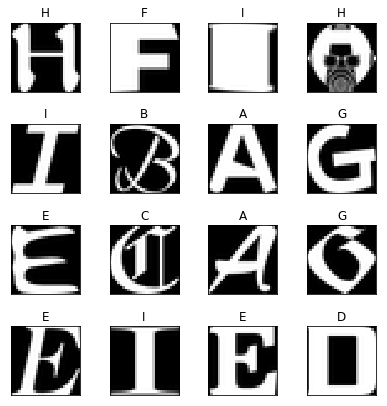

In [16]:
fName = os.path.join(pDir,"samples_of_X_{}.png".format(rev))
XList, TList = select_random_samples(X,L,16)
plot_samples(XList, TList, fName = fName)


## Part 4   
Go through the XZCVP procedure to produce P which is the 2D approximation to X. Produce a 2D scatterplot showing the two classes. Plot the mean vector `mu` and 16 eigenvectors calculated in completing this step.

In [17]:
def getPCA(X) :
    C = np.cov(X,rowvar=False)
    w, U = np.linalg.eigh(C)
    
    # reorder the eigenvector and eigenvector in decreasing order of eigenvalue
    V = U[:,::-1] # eigenvector
    s = w[::-1]   # eigenvalue
    return C, V, s

In [18]:
C, V, s = getPCA(X)
mu = np.mean(X,axis=0)
Z = X - mu

Check results.

In [19]:
print "shape of mu :", mu.shape
print "max of mu   :", mu.max()
print "min of mu   :", mu.min()

shape of mu : (784L,)
max of mu   : 172.874566667
min of mu   : 38.62675


In [20]:
print "shape of Z  :", Z.shape
print "max of Z    :", Z.max()
print "min of Z    :", Z.min()
print "max of mean(Z) :", Z.mean(axis=0).max()
print "min of mean(Z) :", Z.mean(axis=0).min()

shape of Z  : (60000L, 784L)
max of Z    : 216.37325
min of Z    : -172.874566667
max of mean(Z) : 7.99196205511e-13
min of mean(Z) : -8.80027073435e-13


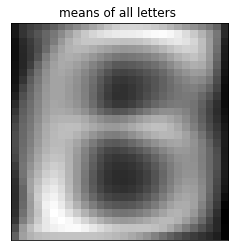

In [21]:
fName = os.path.join(pDir,"mean_of_X_{}.png".format(rev))
plot_sample(mu,"means of all letters ",fName=fName)

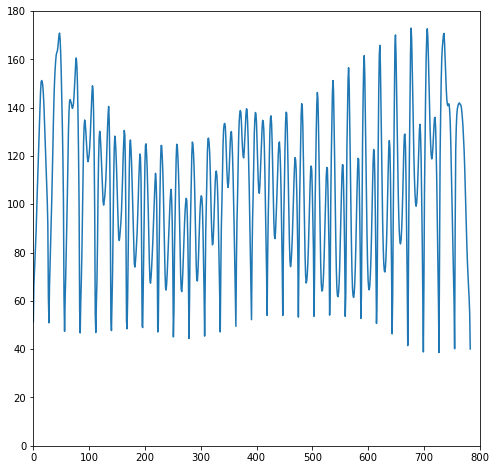

In [22]:
fig = plt.figure()
plt.plot(range(len(mu)),mu)
plt.ylim([0,180])
plt.xlim([0,800])
fig.set_size_inches(8,8)
fName = os.path.join(pDir,'mean_{}.png'.format(rev))
savefig(fName, bbox_inches='tight')
plt.show()

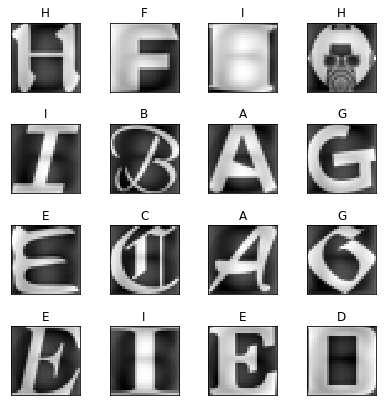

In [23]:
fName = os.path.join(pDir,"samples_of_Z_{}.png".format(rev))
savefig(fName, bbox_inches='tight')
plot_random_samples(Z,L,fName=fName)

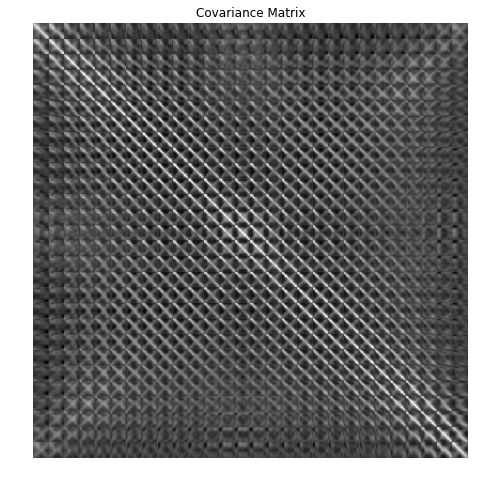

In [24]:
fig = plt.figure()
plt.imshow(C, interpolation='None', cmap=cm.gray)
plt.axis("off")
plt.title("Covariance Matrix")
fig.set_size_inches(8,8)
fName = os.path.join(pDir,'cov_{}.png'.format(rev))
savefig(fName, bbox_inches='tight')
plt.show()

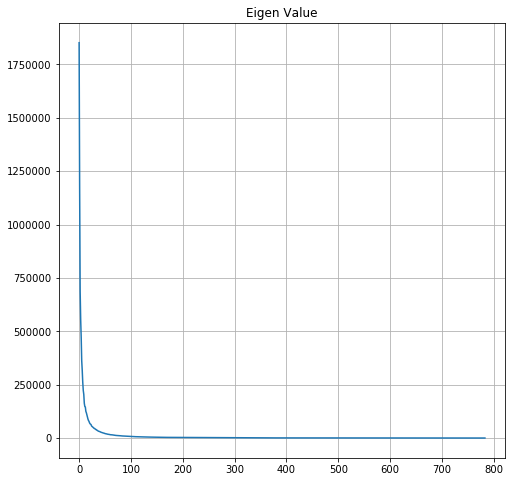

In [25]:
fig = plt.figure()
plt.plot(range(len(s)),s)
plt.title("Eigen Value")
plt.grid("on")
fig.set_size_inches(8,8)
fName = os.path.join(pDir,'eigen_value_{}.png'.format(rev))
savefig(fName, bbox_inches='tight')
plt.show()

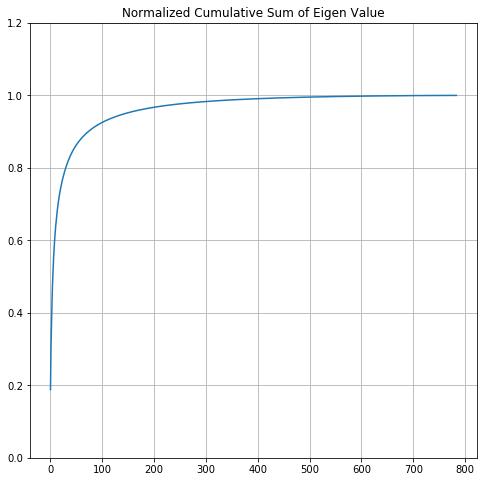

In [26]:
fig = plt.figure()
plt.plot(range(len(s)),s.cumsum()/s.sum())
plt.title("Normalized Cumulative Sum of Eigen Value")
plt.ylim([0,1.2])
plt.grid("on")
fig.set_size_inches(8,8)
fName = os.path.join(pDir,'eigen_value_cum_sum_{}.png'.format(rev))
savefig(fName, bbox_inches='tight')
plt.show()

In [27]:
print "L2 norm of (V*V.T - I) :", np.linalg.norm(np.dot(V,V.T) - np.identity(V.shape[0]))
print "Max of (V.T*V - I)     :", np.max(np.dot(V.T,V) - np.identity(V.shape[0]))
print "Min of (V.T*V - I)     :", np.min(np.dot(V.T,V) - np.identity(V.shape[0]))
print "L2 norm of (V*V.T - I) :", np.linalg.norm(np.dot(V,V.T) - np.identity(V.shape[0]))
print "Max of (V.T*V - I)     :", np.max(np.dot(V.T,V) - np.identity(V.shape[0]))
print "Min of (V.T*V - I)     :", np.min(np.dot(V.T,V) - np.identity(V.shape[0]))

L2 norm of (V*V.T - I) : 7.27583687264e-14
Max of (V.T*V - I)     : 3.33066907388e-15
Min of (V.T*V - I)     : -2.18922102668e-15
L2 norm of (V*V.T - I) : 7.27583687264e-14
Max of (V.T*V - I)     : 3.33066907388e-15
Min of (V.T*V - I)     : -2.18922102668e-15


In [28]:
C2 = np.dot(V,np.dot(np.diag(s),V.T))
print "L2 norm of (V*S*V.T - C) :", np.linalg.norm(C-C2)
print "Max of (V*S*V.T - C)     :", np.max(C-C2)
print "Min of (V*S*V.T - C)     :", np.min(C-C2)

L2 norm of (V*S*V.T - C) : 6.40870069017e-09
Max of (V*S*V.T - C)     : 1.23691279441e-10
Min of (V*S*V.T - C)     : -1.80079950951e-10


Plot the first 16 principle components.

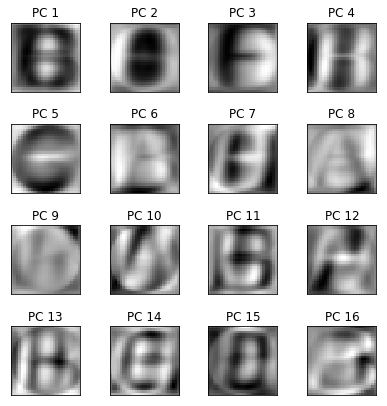

In [29]:
m= 16
tittles = ["PC {}".format(x+1) for x in range(m)]
fName = os.path.join(pDir,'samples_of_pc_{}.png'.format(rev))
plot_samples(V.T[:m], tittles, width=28, ncol=4, fName=fName)

Use `n` principle components for classification.

In [30]:
n = 50

P = np.dot(Z,V[:,:n])
R = np.dot(P,V[:,:n].T)
RX = R + mu

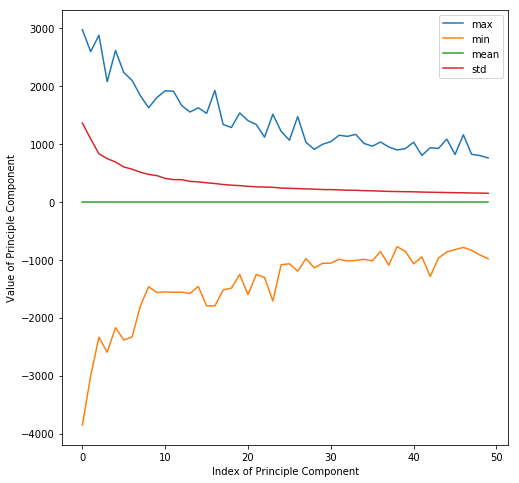

In [31]:
fig = plt.figure()
plt.plot(range(n),P.max(axis=0),label="max")
plt.plot(range(n),P.min(axis=0),label="min")
plt.plot(range(n),P.mean(axis=0),label="mean")
plt.plot(range(n),P.std(axis=0),label="std")
plt.ylabel("Value of Principle Component")
plt.xlabel("Index of Principle Component")
plt.legend()
fig.set_size_inches(8,8)
fName = os.path.join(pDir,'describe_PC_n{}_{}.png'.format(n,rev))
savefig(fName, bbox_inches='tight')
plt.show()

In [32]:
print P.max()
print P.min()
print P.shape

2970.94607214
-3852.0903665
(60000L, 50L)


Display scatter plot of a list of letters.

In [33]:
a = list("ABCD")
print a
print "".join(a)

['A', 'B', 'C', 'D']
ABCD


In [34]:
def scatter_plot(P,L,pcIdx1,pcIdx2,letterList,rev) :
    fig = plt.figure()
    # following the convention in lecture note ScatterPlot.html
    colors = ["r","lime","b","y","c","m","k","tan","pink","darkred"]
    for i, letter in enumerate(letterList) :
        plt.scatter(P[L==letter,pcIdx2],P[L==letter,pcIdx1],s=0.1,c=colors[i],label=letter)
    plt.axes().set_aspect('equal')
    #plt.axes().set_aspect('equal', 'datalim')
    plt.xlabel("Principle Component {}".format(pcIdx2))
    plt.ylabel("Principle Component {}".format(pcIdx1))
    plt.axhline(0, color='grey')
    plt.axvline(0, color='grey')
    plt.ylim([-5000,5000])
    plt.xlim([-5000,5000])
    plt.legend()
    plt.gca().invert_yaxis()
    fig.set_size_inches(8,8)
    fName = os.path.join(pDir,'scatter_PC{}_PC{}_{}_{}.png'.format(pcIdx1,pcIdx2,"".join(letterList),rev))
    savefig(fName, bbox_inches='tight')    
    plt.show()

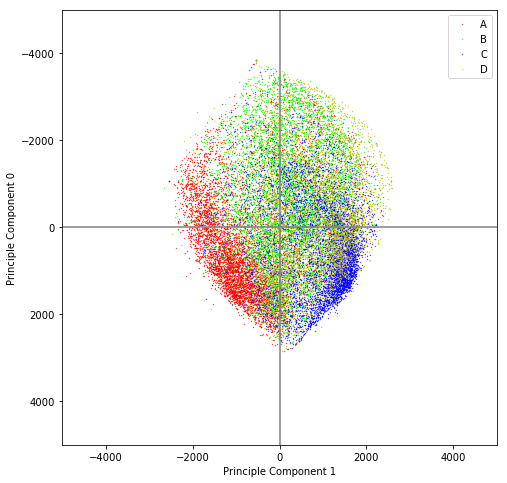

In [35]:
scatter_plot(P,L,0,1,["A","B","C", "D"],rev)

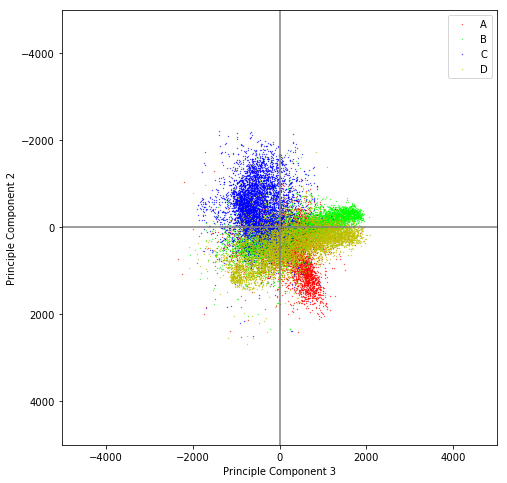

In [36]:
scatter_plot(P,L,2,3,["A","B","C","D"],rev)

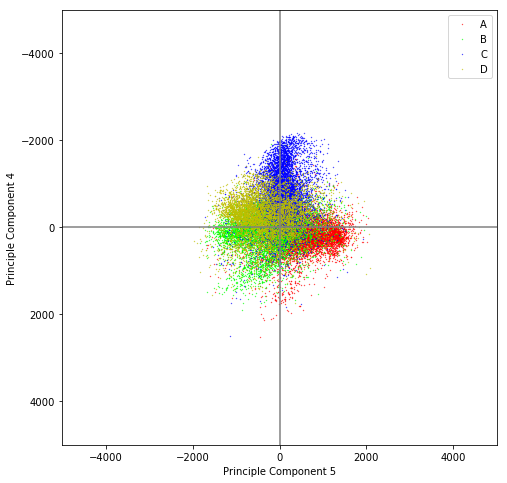

In [37]:
scatter_plot(P,L,4,5,["A","B","C","D"],rev)

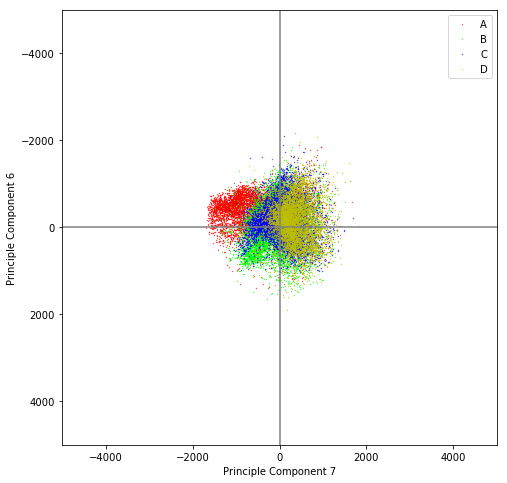

In [38]:
scatter_plot(P,L,6,7,["A","B","C","D"],rev)

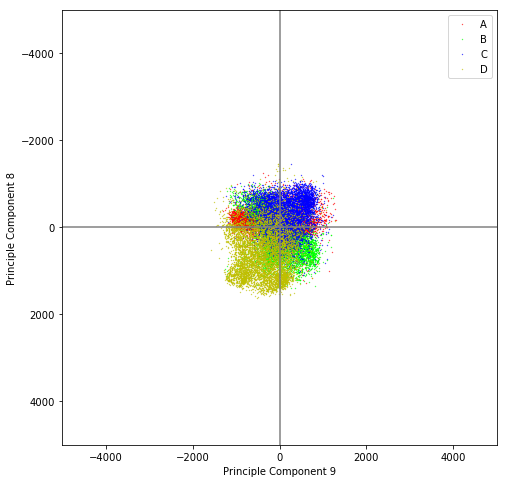

In [39]:
scatter_plot(P,L,8,9,["A","B","C","D"],rev)

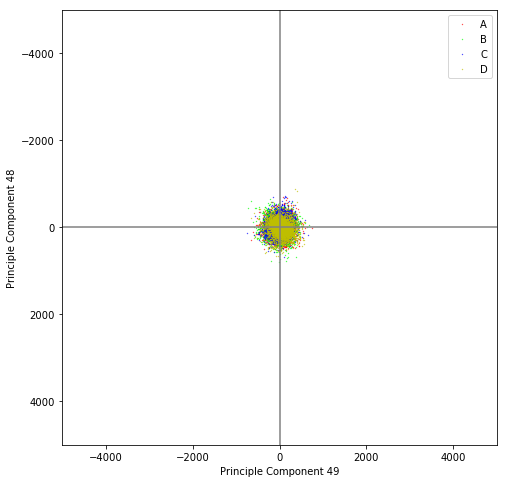

In [40]:
scatter_plot(P,L,n-2,n-1,["A","B","C","D"],rev)

## Part 5    
Visually verify that the corresponding element of P, when projected back to 784 dimensions and visualized as an image still looks like the original image. That is, visually verify that reduction in dimension does not significantly compromise the identity of the samples. 

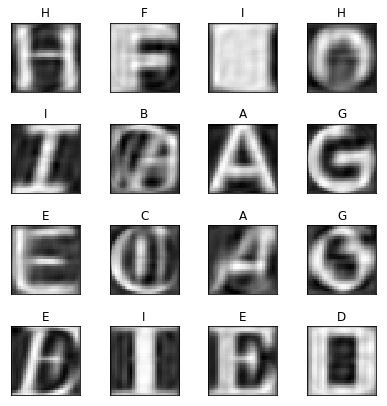

In [41]:
fName = os.path.join(pDir,"samples_of_RX_n{}_{}.png".format(n,rev))
plot_random_samples(RX,L,fName=fName)

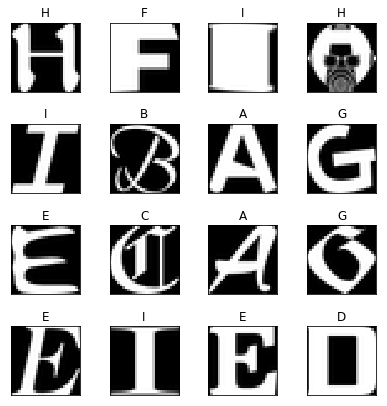

In [42]:
plot_random_samples(X,L)

## Part 6    
Build a Bayesian classifier assuming that the feature vectors are distributed normally in the reduced dimensional space.  In order to use the  classifier on a 784D query, the mean vectors and eigenvectors (Step 4 above) are needed.

## 6.1 Bayesian
Build a $n$-D Bayesian classifier assuming that the feature vectors are distributed normally in the reduced dimensional space. 


#### Number of samples in each letter

In [43]:
N = P.shape[0]
NList = np.array([P[T==x].shape[0] for x in digits])

In [44]:
print "NList =", NList
print "N     =", N

NList = [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
N     = 60000


#### Mean of the principle components of each letter 

In [45]:
muList = np.array([P[T==x].mean(axis=0) for x in digits])

In [46]:
print muList.shape

(10L, 50L)


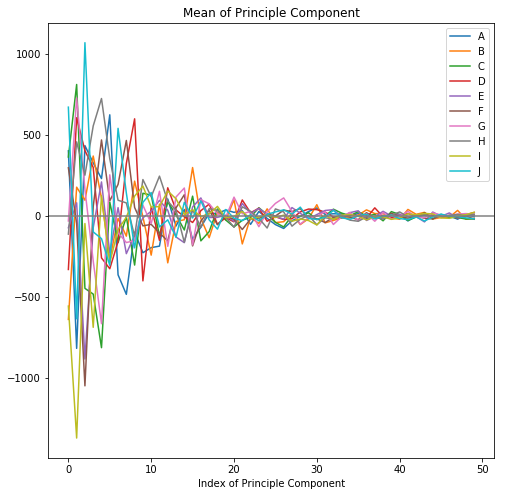

In [47]:
fig = plt.figure()
plt.plot(muList.T)
plt.title("Mean of Principle Component")
plt.xlabel("Index of Principle Component")
plt.axhline(0, color='grey')
plt.legend(letters,loc='upper right')
fig.set_size_inches(8,8)
fName = os.path.join(pDir,'mean_of_pc_n{}_{}.png'.format(n,rev))
savefig(fName, bbox_inches='tight')
plt.show()

#### Covariance matrix of the principle component of each letter

In [48]:
covList = np.array([np.cov(P[T==x],rowvar=False) for x in digits])

In [49]:
print covList.shape

(10L, 50L, 50L)


## Part 7   
Run P through the classifiers and record the results (e.g. what is X recognized as? With what probability? 

### Functions for classification

#### A function to map the label T into a matrix by Kesler construction

In [50]:
def map_kesler(T,digits) :
    Tk = (T.reshape(-1,1) == digits).astype(int) * 2 -1
    return np.array(Tk)

In [51]:
Tk = map_kesler(T,digits)

In [52]:
pd.DataFrame(T,columns=["T"]).join(pd.DataFrame(Tk)).head()

,T,0,1,2,3,4,5,6,7,8,9
0,5,-1,-1,-1,-1,-1,1,-1,-1,-1,-1
1,8,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
2,8,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
3,6,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
4,3,-1,-1,-1,1,-1,-1,-1,-1,-1,-1


#### A function to augment a data matrix `X`

In [53]:
def augment(X) :
    Xa = np.insert(X,0,1,axis=1)
    return Xa

In [54]:
print P[:4,:2]

[[ -546.72513858   818.43762512]
 [ -926.19936407 -2848.70416962]
 [ 1820.17403765   914.3522124 ]
 [ 1428.52857547   316.85666829]]


In [55]:
print augment(P[:4,:2])

[[  1.00000000e+00  -5.46725139e+02   8.18437625e+02]
 [  1.00000000e+00  -9.26199364e+02  -2.84870417e+03]
 [  1.00000000e+00   1.82017404e+03   9.14352212e+02]
 [  1.00000000e+00   1.42852858e+03   3.16856668e+02]]


#### Functions to augment and apply kernel to a data matrix `X`

In [56]:

def kernel_aug_vector(xa) :
    'Applies 2nd order kernel to an augmented 1d vector'
    if xa.ndim != 1 :
        raise ValueError("Array expected to be 1d")
    xa_size = xa.size
    xa_2d = xa.reshape((1,xa_size))
    prod = np.dot(xa_2d.T,xa_2d)
    idxs = np.triu_indices(xa_size)
    return prod[idxs]

def kernel_aug(Xa) :
    'Applies 2nd order kernel to an augmented set of input vectors'
    Xak = [kernel_aug_vector(xa) for xa in Xa]
    Xak = np.array(Xak)
    return Xak

def augment_and_kernel_vector(x) :
    'Augments and applies 2nd order kernel to a 1d vector'
    xa = np.insert(x,0,1)
    return kernel_aug_vector(xa)

def augment_and_kernel(X) :
    'Augments and applies 2nd order kernel to set of input vectors'
    Xak = [augment_and_kernel_vector(x) for x in X]
    Xak = np.array(Xak)
    return Xak


In [57]:
print P[:4,:2]

[[ -546.72513858   818.43762512]
 [ -926.19936407 -2848.70416962]
 [ 1820.17403765   914.3522124 ]
 [ 1428.52857547   316.85666829]]


In [58]:
print augment_and_kernel(P[:4,:2])

[[  1.00000000e+00  -5.46725139e+02   8.18437625e+02   2.98908377e+05
   -4.47460424e+05   6.69840146e+05]
 [  1.00000000e+00  -9.26199364e+02  -2.84870417e+03   8.57845262e+05
    2.63846799e+06   8.11511545e+06]
 [  1.00000000e+00   1.82017404e+03   9.14352212e+02   3.31303353e+06
    1.66428016e+06   8.36039968e+05]
 [  1.00000000e+00   1.42852858e+03   3.16856668e+02   2.04069389e+06
    4.52638805e+05   1.00398148e+05]]


#### A function to train a linear classifier

In [59]:
def train_linear_classifier(Xa,T) :
    Xa_pinv = np.linalg.pinv(Xa)
    Wt = np.dot(Xa_pinv,T)
    return Wt

#### A function to predict the class label of `Xa` given the weight `Wt` assuming that the predicted label is the column index.

In [60]:
def linear_classify(Xa,Wt) :
    T_pred =  np.dot(Xa,Wt)
    return np.argmax(T_pred, axis=1)

### Functions for confusion matrix and related information

In [61]:
def getCount(groundTruth,gClass,predicted,pClass) :
    return np.sum(np.logical_and(groundTruth == gClass, predicted == pClass))
  
def getTP(groundTruth,predicted,pClass) :
    return np.sum(np.logical_and(groundTruth == pClass, predicted == pClass))

def getTN(groundTruth,predicted,pClass) :
    return np.sum(np.logical_and(groundTruth != pClass, predicted != pClass))
   
def getFP(groundTruth,predicted,pClass) :
    return np.sum(np.logical_and(groundTruth != pClass, predicted == pClass))

def getFN(groundTruth,predicted,pClass) :
    return np.sum(np.logical_and(groundTruth == pClass, predicted != pClass))

def get_acc(groundTruth,predicted) :
    return np.sum(groundTruth == predicted)/float(predicted.shape[0])

def get_CM2(groundTruth,predicted,pClass) :
    TP = getTP(groundTruth,predicted,pClass)
    TN = getTN(groundTruth,predicted,pClass)
    FP = getFP(groundTruth,predicted,pClass)
    FN = getFN(groundTruth,predicted,pClass)
    return np.array([[TP, FN], [FP, TN]])

def get_sensitivity(TP, FN, FP, TN) :
    return TP / float(TP + FN)
    
def get_specificity(TP, FN, FP, TN) :
    return TN / float(FP+TN)
    
def get_ppv(TP, FN, FP, TN) :
    return TP / float(TP+FP)    
    
def get_accuracy(TP, FN, FP, TN) :
    return (TP + TN) / float(TP + FN + FP + TN)   

def get_CM(groundTruth,predicted,classList) :
    CM = np.zeros((len(classList),len(classList)))
    for i, t in enumerate(classList) :
        for j, p in enumerate(classList) : 
          CM[i,j] =  np.sum(np.logical_and(groundTruth == t, predicted == p))  
    CM = pd.DataFrame(CM)
    CM.columns = classList
    CM.index = classList
    return CM

#### Classify the training and test set with `n` principle components
It is not very fast. Please wait.

The eigenvectors `V` and the mean vector `mu` were previously computed by
```
C, V, s = getPCA(X)
mu = np.mean(X,axis=0)
```

In [ ]:
def train_and_test(X_train,T_train,X_test,T_test,digits,V,mu,n):
    print "Training Classifier with {} PC".format(n)
    Z = X_train - mu
    P = np.dot(Z,V[:,:n])

    Tk = map_kesler(T_train,digits)
    
    Xa = augment_and_kernel(P)
    Wt = train_linear_classifier(Xa,Tk)
    T_pred = linear_classify(Xa,Wt)
     
    print "Testing  Classifier with {} PC".format(n)
    Z_test = X_test - mu
    P_test = np.dot(Z_test,V[:,:n])

    Xa_test = augment_and_kernel(P_test)
    T_pred_test = linear_classify(Xa_test,Wt)
    
    return T_pred, T_pred_test

#### Collect accuracy as a function of the number of PC for training and testing
Find the accuracy of the classifier for `1` to `maxNumPC` principle components. If the results are previously cached, it will load the previous results. Otherwise, it will compute the new results. 

The accuracy of the training and test data are stored in the files specified by `accName` and `accTestName` respectively. The execution time for training and test  are stored in the file specified by `timeName`.

For `maxNumPC = 50`, it tooked about 30 seconds to compute on a Intel Core i7-4661 3.5Ghz machine.

In [ ]:
maxNumPC = 50

accName = os.path.join(rDir,'acc_train_n{}_{}.csv'.format(maxNumPC,rev))
accTestName = os.path.join(rDir,'acc_test_n{}_{}.csv'.format(maxNumPC,rev))
timeName = os.path.join(rDir,'time_n{}_{}.csv'.format(maxNumPC,rev))

try:
    accList = np.loadtxt(accName, ndmin=1, delimiter=',')
    accTestList = np.loadtxt(accTestName, ndmin=1, delimiter=',')
    timeList = np.loadtxt(timeName, ndmin=1, delimiter=',')
    print 'Imported {}'.format(accName)
    print 'Imported {}'.format(accTestName)
    print 'Imported {}'.format(timeName,rev)
    print "accList.shape =", accList.shape
    print "accTestList.shape =", accTestList.shape
    print "timeList.shape =", timeList.shape
except IOError:
    accList = []
    accTestList = []
    timeList = []
    for n in range(1,maxNumPC+1) :
        start = time.time()
        T_pred, T_pred_test = train_and_test(X,T,X_test,T_test,digits,V,mu,n)
        end = time.time()

        accuracy_train = get_acc(T_pred , T) * 100
        accuracy_test  = get_acc(T_pred_test , T_test) * 100

        myTime = end - start
        timeList.append(myTime)    
        accList.append(accuracy_train)
        accTestList.append(accuracy_test)

        print "Time for train+test with {} PC        = {} seconds".format(n,myTime)    
        print "Accuracy for training data with {} PC = {}".format(n,accuracy_train)
        print "Accuracy for testing  data with {} PC = {}".format(n,accuracy_test)
        print

    accList = np.array(accList)
    accTestList = np.array(accTestList)
    timeList = np.array(timeList)
    
    np.savetxt(accName, accList, delimiter=',')
    np.savetxt(accTestName, accTestList, delimiter=',')
    np.savetxt(timeName, timeList, delimiter=',')

Training Classifier with 1 PC
Testing  Classifier with 1 PC
Time for train+test with 1 PC        = 3.04800009727 seconds
Accuracy for training data with 1 PC = 14.9583333333
Accuracy for testing  data with 1 PC = 15.45

Training Classifier with 2 PC
Testing  Classifier with 2 PC
Time for train+test with 2 PC        = 4.11100006104 seconds
Accuracy for training data with 2 PC = 25.5216666667
Accuracy for testing  data with 2 PC = 26.52

Training Classifier with 3 PC
Testing  Classifier with 3 PC
Time for train+test with 3 PC        = 3.66700005531 seconds
Accuracy for training data with 3 PC = 41.0866666667
Accuracy for testing  data with 3 PC = 43.85

Training Classifier with 4 PC
Testing  Classifier with 4 PC
Time for train+test with 4 PC        = 4.20199990273 seconds
Accuracy for training data with 4 PC = 48.3783333333
Accuracy for testing  data with 4 PC = 52.15

Training Classifier with 5 PC
Testing  Classifier with 5 PC
Time for train+test with 5 PC        = 3.76800012589 seconds

Testing  Classifier with 38 PC
Time for train+test with 38 PC        = 19.6840000153 seconds
Accuracy for training data with 38 PC = 86.3533333333
Accuracy for testing  data with 38 PC = 92.19

Training Classifier with 39 PC
Testing  Classifier with 39 PC
Time for train+test with 39 PC        = 21.2699999809 seconds
Accuracy for training data with 39 PC = 86.4983333333
Accuracy for testing  data with 39 PC = 92.39

Training Classifier with 40 PC
Testing  Classifier with 40 PC
Time for train+test with 40 PC        = 23.2550001144 seconds
Accuracy for training data with 40 PC = 86.6516666667
Accuracy for testing  data with 40 PC = 92.56

Training Classifier with 41 PC
Testing  Classifier with 41 PC
Time for train+test with 41 PC        = 24.6759998798 seconds
Accuracy for training data with 41 PC = 86.76
Accuracy for testing  data with 41 PC = 92.64

Training Classifier with 42 PC
Testing  Classifier with 42 PC
Time for train+test with 42 PC        = 25.7010002136 seconds
Accuracy for tr

In [ ]:
fig = plt.figure()
m = len(accList)+1
nPC = range(1,m)
plt.plot(nPC,accList,label="training")
plt.plot(nPC,accTestList,label="testing")
plt.ylabel("Accuracy in %")
plt.xlabel("Number of Principle Component")
plt.title("Traning and Testing Accuracy")
plt.grid("on")
plt.legend()
fig.set_size_inches(8,8)
fName = os.path.join(pDir,'accuracy_n{}_{}.png'.format(n,rev))
savefig(fName, bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure()
m = len(accList)+1
nPC = range(1,m)
plt.plot(nPC,timeList,label="time")
plt.ylabel("time in second")
plt.xlabel("Number of Principle Component")
plt.title("Traning and Testing Time")
plt.grid("on")
plt.legend()
fig.set_size_inches(8,8)
fName = os.path.join(pDir,'time_n{}_{}.png'.format(n,rev))
savefig(fName, bbox_inches='tight')
plt.show()

In [ ]:
numPC = 16
cb, cb_test = train_and_test(X,T,X_test,T_test,digits,V,mu,numPC)

In [ ]:
CM = get_CM(T, cb, digits)
CM.columns = letters
CM.index = letters
fName = os.path.join(rDir,"cm_train_n{}_{}.csv".format(numPC,rev))
CM.to_csv(fName)
CM

In [ ]:
CM_test = get_CM(T_test , cb_test, digits)
CM_test.columns = letters
CM_test.index = letters
fName = os.path.join(rDir,"cm_test_n{}_{}.csv".format(numPC,rev))
CM.to_csv(fName)
CM

In [ ]:
accuracy_train  = get_acc(T, cb) * 100
print "accuracy for training =", accuracy_train

In [ ]:
accuracy_test  = get_acc(T_test , cb_test) * 100
print "accuracy for testing  =", accuracy_test